# CNN for Sentence Classification

### Libraries used

In [80]:
# Tools
import os
import time
import random
import shutil
from argparse import Namespace
import matplotlib.pyplot as plt
from typing import Callable, Tuple

# Preprocessing
from nltk.tokenize import TweetTokenizer
from nltk import FreqDist
import pandas as pd
import numpy as np

# PyTorch
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# word embeddings
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

Set seeds for reproducibility

In [81]:
args = Namespace()

args.seed = 1111
random.seed(args.seed) # python seed
np.random.seed(args.seed) # numpy seed
torch.manual_seed(args.seed) # torch seed
torch.backends.cudnn.benchmark = False # causes cuDNN to deterministically select algorithms for Neural Network operations
torch.backends.cudnn.deterministic = True # Use deterministic algorithms instead of non-deterministic where available

### Load Dataset

In [82]:
!gdown https://drive.google.com/uc?id=1CL2rtDbi7HU1OY8JNrgIlq5TYVhgvAzZ
!unzip -qq mex-a3t.zip

zsh:1: no matches found: https://drive.google.com/uc?id=1CL2rtDbi7HU1OY8JNrgIlq5TYVhgvAzZ
unzip:  cannot find or open mex-a3t.zip, mex-a3t.zip.zip or mex-a3t.zip.ZIP.


Set split hyperparameter and split data

In [83]:
args.val_size = 0.1

In [84]:
path="/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/practicas/03_practica/"
X_train = pd.read_csv(path+'mex20_train.txt', sep='\r\n', engine='python', header=None).loc[:,0]
y_train = pd.read_csv(path+'mex20_train_labels.txt', header=None).loc[:,0]
#.values.tolist()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=args.val_size, random_state=args.seed)

X_test = pd.read_csv(path+'mex20_val.txt', sep='\r\n', engine='python', header=None).loc[:,0]
y_test = pd.read_csv(path+'mex20_val_labels.txt', header=None).loc[:,0]

Functions to build vocabulary

In [85]:
def get_vocab(corpus: pd.DataFrame,
              tokenizer: Callable[[str], list],
              max_features: int) -> set:
    freq_dist = FreqDist([w.lower() for sentence in corpus\
                                    for w in tokenizer(sentence)])

    sorted_words = sortFreqDict(freq_dist)[:min(max_features-1, len(freq_dist))]
    w2idx = {word: i+1 for i, word in enumerate(sorted_words)}

    # Append <pad> token with 0 index
    sorted_words.append('<pad>')
    w2idx['<pad>'] = 0

    return set(sorted_words), w2idx

def sortFreqDict(freq_dist: FreqDist) -> list:
    freq_dict = dict(freq_dist)
    return sorted(freq_dict, key=freq_dict.get, reverse=True)
def create_vocabulary_inv(word_list):
    # Crea un diccionario que mapea palabras a índices
    vocabulary_inv = {idx: word for idx, word in enumerate(word_list)}
    return vocabulary_inv

In [86]:
# Set vocab size
args.vocab_size = 5000

tk = TweetTokenizer()
vocab, w2idx = get_vocab(X_train, tk.tokenize, args.vocab_size)

### Define Dataset, collate_fn and Dataloader

Define Map-style Dataset (one that implements the `__getitem__()` and `__len__()` protocols) class for processing each observation in the correct format for the model

In [87]:
class TweeterDataset(Dataset):
    def __init__(self,
                 X: pd.DataFrame,
                 y: pd.DataFrame,
                 vocab: set,
                 w2idx: dict,
                 tokenizer: Callable[[str], list],
                 max_seq_len: int):
        self.X = X
        self.y = y
        self.vocab = vocab
        self.w2idx = w2idx
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Get sequence of token ids
        sentence = self.X.iloc[idx]
        tokens = [self.w2idx[w] for w in self.tokenizer(sentence) if w in self.vocab]

        # Truncate sequence up to max_seq_len
        truncate_len = min(len(tokens), self.max_seq_len)
        tokens = tokens[:truncate_len]

        # Get true label
        label = self.y.iloc[idx]

        return torch.LongTensor(tokens), torch.LongTensor([label])

Define function to collate samples fetched by the sampler from the Dataset. The Dataloader will return the output of this `collate_fn` that we define.

In [88]:
def collate_fn(batch):
    # Get X
    batch_tokens = [row[0] for row in batch]
    # Get y
    batch_labels = torch.LongTensor([row[1] for row in batch]).to(torch.float)

    # Pad with 0 (to the rigth) shorter sequences than max_seq_len
    padded_batch_tokens = pad_sequence(batch_tokens, batch_first=True)

    return padded_batch_tokens, batch_labels.unsqueeze(1)

Build Dataloaders to process batches of observations from the Datasets

In [89]:
# Set batch size in args
args.batch_size = 64

# Num workers
args.num_workers = 0

# Maximum sequence length
args.max_seq_len = 20

In [90]:
# Training
train_dataset = TweeterDataset(X_train, y_train, vocab, w2idx, tk.tokenize, args.max_seq_len)
train_loader = DataLoader(train_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=True)

# Validation
val_dataset = TweeterDataset(X_val, y_val, vocab, w2idx, tk.tokenize, args.max_seq_len)
val_loader = DataLoader(val_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=False)

# Test
test_dataset = TweeterDataset(X_test, y_test, vocab, w2idx, tk.tokenize, args.max_seq_len)
test_loader = DataLoader(test_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=False)

When iterating a ```Dataloader```, the whole order of execution to get a batch is roughly the following:

1. A `Sampler` object in `batch_sampler` variable, retrieves a batch of indices.

2. For each retrieved index, get the data from the defined `Dataset` object, process all the batch samples with the defined `collate_fn` and return the result:

    ```
    for indices in batch_sampler:
        yield collate_fn([dataset[i] for i in indices])
    ```




Testing train Dataloader

In [91]:
batch_ = next(iter(train_loader))
print(f'X_batch shape: {batch_[0].shape}')
print(f'y_batch shape: {batch_[1].shape}')

X_batch shape: torch.Size([64, 20])
y_batch shape: torch.Size([64, 1])


### Define CNN text classifier

In [92]:
class CNNTextCls(nn.Module):
    def __init__(self, args, embeddings=None, freeze=False):
        super(CNNTextCls, self).__init__()

        if embeddings is not None:
            self.emb = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))
            if freeze:
                self.emb.weight.requires_grad=False
        else:
            self.emb = nn.Embedding(args.vocab_size, args.d)

        conv_block_list = []

        for k in args.filter_sizes:
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=args.d, out_channels=args.num_filters, kernel_size=k, stride=1),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=(args.max_seq_len-k+1))
            )
            conv_block_list.append(conv_block)

        self.conv_block_list = nn.ModuleList(conv_block_list)
        self.dropout = nn.Dropout(args.dropout)
        self.fc = nn.Linear(args.num_filters*len(args.filter_sizes), 1)

    def forward(self, x):
        '''
        B: batch size
        L: sequence length
        D: embedding dim
        C: Convolution output channels (number of filters)
        k: Convolution kernel size
        N: Number of convolution blocks

        x shape: (B, L)
        '''
        x = self.emb(x) # (B, L, D)
        x = x.transpose(1,2) # (B, D, L) conv1d expects L in last dimension

        x_filter = []
        for conv_block in self.conv_block_list: # Conv1d -> ReLU -> MaxPool1d
            x_filter.append(conv_block(x).squeeze(2)) # (B, C, L-k+1) -> ReLU -> (B, C, 1) -> (B, C) after squeeze

        x_cat = torch.cat(x_filter, dim=1) # (B, C*N)
        x = self.dropout(x_cat)
        return self.fc(x)

### Helper functions for model evaluation

In [93]:
def model_eval(data, model, gpu=False):
    with torch.no_grad():
        preds, tgts = [], []
        for input, labels in data:
            if gpu:
                input = input.cuda()

            outputs = model(input)

            # Get prediction for Accuracy
            y_pred = y_pred = torch.round(torch.sigmoid(outputs.detach())).cpu().numpy()

            tgt = labels.numpy()
            tgts.append(tgt)
            preds.append(y_pred)

    tgts = [e for l in tgts for e in l]
    preds = [e for l in preds for e in l]

    metrics = {
        "accuracy": accuracy_score(tgts, preds),
    }

    return metrics

### Helper function to save model

In [107]:
def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint1.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best1.pt"))

### Training function

In [108]:
def train(args, model, train_loader, val_loader, optimizer, criterion, scheduler):
    best_metric = 0
    metric_history = []
    train_metric_history = []

    for epoch in range(args.num_epochs):
        epoch_start_time = time.time()
        loss_epoch = []
        training_metrics = []
        model.train()

        for input, labels in train_loader:
            # If GPU available
            if args.use_gpu:
                input = input.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(input)

            loss = criterion(outputs, labels)
            loss_epoch.append(loss.item())

            # Get training metric
            preds = torch.round(torch.sigmoid(outputs.detach())).cpu().numpy()
            training_metrics.append(accuracy_score(labels.cpu().numpy(), preds))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Get metric in training dataset
        mean_epoch_accuracy = np.mean(training_metrics)
        train_metric_history.append(mean_epoch_accuracy)

        # Get metric in validation dataset
        model.eval()
        tuning_metric = model_eval(val_loader, model, gpu=args.use_gpu)
        metric_history.append(tuning_metric['accuracy'])

        # Update scheduler
        scheduler.step(tuning_metric['accuracy'])

        # Check for metric improvement
        is_improvement = tuning_metric['accuracy'] > best_metric
        if is_improvement:
            best_metric = tuning_metric['accuracy']
            n_no_improve = 0
        else:
            n_no_improve += 1

        # Save best model if metric improved
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        # Early stopping
        if n_no_improve >= args.patience:
            print("No improvement. Breaking out of loop.")
            break

        print ('Epoch [{}/{}], Loss: {:.4f} - Train Accuracy: {:.4f} - Val Accuracy: {:.4f} - Epoch time: {:.2f} s'
            .format(epoch+1, args.num_epochs, np.mean(loss_epoch), mean_epoch_accuracy, tuning_metric['accuracy'], (time.time()- epoch_start_time)))

    return train_metric_history, metric_history

In [96]:
print(torch.__version__)

2.3.0


### Train CNN classifier

In [126]:
# Model hyperparameters
args.d = 100 # Dimension of word embeddings
args.filter_sizes = [3, 4]
args.num_filters = 100
args.dropout = 0.1

# Training hyperparameters
args.lr = 1e-2
args.num_epochs = 15
args.patience = 10

# Scheduler hyperparameters
args.lr_patience = 5
args.lr_factor = 0.5

# Saving directory
args.savedir = 'model'
os.makedirs(args.savedir, exist_ok=True)

# Create model
model = CNNTextCls(args)

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor
            )

/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [127]:
start_time = time.time()
train_metric_history, val_metric_history = train(args, model, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

Epoch [1/15], Loss: 0.6129 - Train Accuracy: 0.7024 - Val Accuracy: 0.7159 - Epoch time: 2.10 s
Epoch [2/15], Loss: 0.5996 - Train Accuracy: 0.7111 - Val Accuracy: 0.7216 - Epoch time: 1.99 s
Epoch [3/15], Loss: 0.5907 - Train Accuracy: 0.7125 - Val Accuracy: 0.7216 - Epoch time: 1.94 s
Epoch [4/15], Loss: 0.5841 - Train Accuracy: 0.7102 - Val Accuracy: 0.7216 - Epoch time: 1.91 s
Epoch [5/15], Loss: 0.5735 - Train Accuracy: 0.7122 - Val Accuracy: 0.7216 - Epoch time: 2.10 s
Epoch [6/15], Loss: 0.5667 - Train Accuracy: 0.7106 - Val Accuracy: 0.7121 - Epoch time: 1.90 s
Epoch [7/15], Loss: 0.5592 - Train Accuracy: 0.7150 - Val Accuracy: 0.7216 - Epoch time: 1.91 s
Epoch [8/15], Loss: 0.5555 - Train Accuracy: 0.7144 - Val Accuracy: 0.7159 - Epoch time: 1.92 s
Epoch [9/15], Loss: 0.5463 - Train Accuracy: 0.7173 - Val Accuracy: 0.7197 - Epoch time: 1.92 s
Epoch [10/15], Loss: 0.5385 - Train Accuracy: 0.7250 - Val Accuracy: 0.7197 - Epoch time: 1.93 s
Epoch [11/15], Loss: 0.5339 - Train Acc

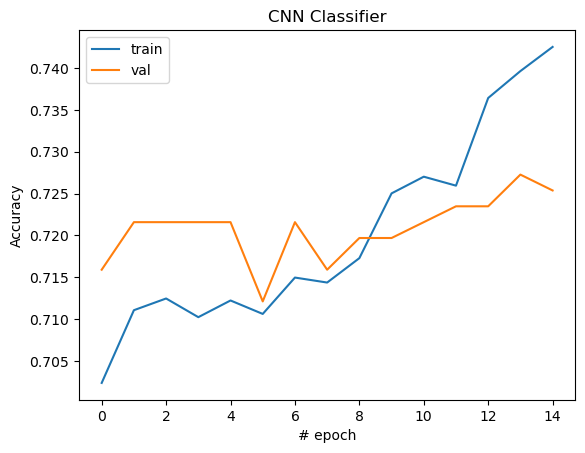

In [128]:
plt.plot(train_metric_history, label='train')
plt.plot(val_metric_history, label='val')
plt.title('CNN Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.show()

CNN-Static

In [101]:
# class CNNTextCls(nn.Module):
#     def __init__(self, args, embeddings=None, freeze=False):
#         super(CNNTextCls, self).__init__()

#         if embeddings is not None:
#             self.emb = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))
#             if freeze:
#                 self.emb.weight.requires_grad=False
#         else:
#             self.emb = nn.Embedding(args.vocab_size, args.d)

#         conv_block_list = []

#         for k in args.filter_sizes:
#             conv_block = nn.Sequential(
#                 nn.Conv1d(in_channels=args.d, out_channels=args.num_filters, kernel_size=k, stride=1),
#                 nn.ReLU(),
#                 nn.MaxPool1d(kernel_size=(args.max_seq_len-k+1))
#             )
#             conv_block_list.append(conv_block)

#         self.conv_block_list = nn.ModuleList(conv_block_list)
#         self.dropout = nn.Dropout(args.dropout)
#         self.fc = nn.Linear(args.num_filters*len(args.filter_sizes), 1)

#     def forward(self, x):
#         x = self.emb(x)  # Pasa los índices de palabras a través de la capa de embedding
#         x = x.permute(0, 2, 1)  # Transpone para que la dimensión de la secuencia esté en la última posición
#         conv_outputs = [conv_block(x) for conv_block in self.conv_block_list]  # Aplica las capas convolucionales
#         pooled_outputs = [nn.functional.max_pool1d(conv_output, conv_output.size(2)).squeeze(2) for conv_output in conv_outputs]  # Aplica max-pooling
#         cat = torch.cat(pooled_outputs, 1)  # Concatena los resultados de las capas convolucionales
#         x = self.dropout(cat)  # Aplica dropout
#         logits = self.fc(x)  # Pasa los resultados a través de la capa fully connected
#         return logits

In [129]:
idx2w = dict((v, k) for k, v in w2idx.items())

In [130]:
idx2w [1]

'que'

In [137]:
# Model hyperparameters
args.d = 300 # Dimension of word embeddings
args.filter_sizes = [3, 4]
args.num_filters = 200 
args.dropout = 0.2

# Training hyperparameters
args.lr = 1e-2
args.num_epochs = 25
args.patience = 10

# Scheduler hyperparameters
args.lr_patience = 5
args.lr_factor = 0.5

# Saving directory
args.savedir = 'model1'
os.makedirs(args.savedir, exist_ok=True)

#Embbedings--------------------------------------------------------------------------------
embedding_model = Word2VecKeyedVectors.load_word2vec_format('GNvectors.bin', binary=True)
embedding_weights = {key: embedding_model[word] if word in embedding_model else
                          np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                     for key, word in idx2w.items()}


# Convertir embedding_weights a una lista de pesos de embedding--
embedding_weights_list = [embedding_weights[idx] for idx in range(len(embedding_weights))]

# Crear el modelo CNNTextCls con embeddings pre-entrenados y freeze=TRUE porque no queremos que se entrenen los parametros
model_static = CNNTextCls(args, embeddings=torch.FloatTensor(embedding_weights_list),freeze=True)

#-----------------------------------------------------------------------------------------

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor
            )

/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [138]:
start_time = time.time()
train_metric_history, val_metric_history = train(args, model_static, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

Epoch [1/25], Loss: 0.6685 - Train Accuracy: 0.7032 - Val Accuracy: 0.7216 - Epoch time: 8.01 s
Epoch [2/25], Loss: 0.6689 - Train Accuracy: 0.7051 - Val Accuracy: 0.7216 - Epoch time: 8.48 s
Epoch [3/25], Loss: 0.6693 - Train Accuracy: 0.7079 - Val Accuracy: 0.7216 - Epoch time: 7.90 s
Epoch [4/25], Loss: 0.6688 - Train Accuracy: 0.7062 - Val Accuracy: 0.7216 - Epoch time: 7.77 s
Epoch [5/25], Loss: 0.6690 - Train Accuracy: 0.7086 - Val Accuracy: 0.7216 - Epoch time: 7.87 s
Epoch [6/25], Loss: 0.6686 - Train Accuracy: 0.7084 - Val Accuracy: 0.7216 - Epoch time: 8.66 s
Epoch [7/25], Loss: 0.6692 - Train Accuracy: 0.7087 - Val Accuracy: 0.7216 - Epoch time: 10.14 s
Epoch [8/25], Loss: 0.6686 - Train Accuracy: 0.7075 - Val Accuracy: 0.7216 - Epoch time: 10.68 s
Epoch [9/25], Loss: 0.6686 - Train Accuracy: 0.7070 - Val Accuracy: 0.7216 - Epoch time: 11.14 s
Epoch [10/25], Loss: 0.6691 - Train Accuracy: 0.7081 - Val Accuracy: 0.7216 - Epoch time: 12.87 s
No improvement. Breaking out of loo

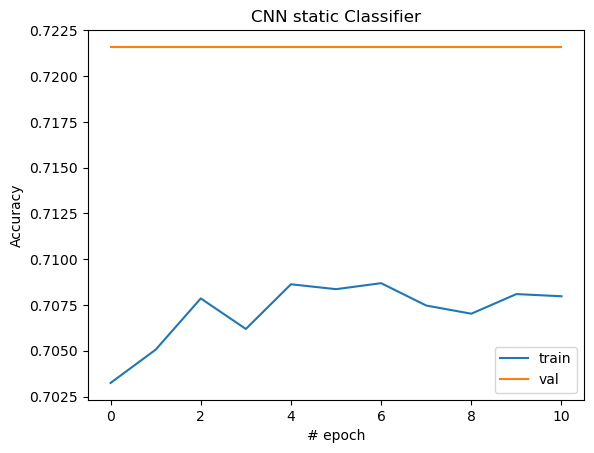

In [140]:
plt.plot(train_metric_history, label='train')
plt.plot(val_metric_history, label='val')
plt.title('CNN static Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.show()

CNN-non-Static

In [141]:
# Model hyperparameters
args.d = 300 # Dimension of word embeddings
args.filter_sizes = [4, 5]
args.num_filters = 200
args.dropout = 0.2

# Training hyperparameters
args.lr = 1e-2
args.num_epochs = 25
args.patience = 10

# Scheduler hyperparameters
args.lr_patience = 5
args.lr_factor = 0.5

# Saving directory
args.savedir = 'model2'
os.makedirs(args.savedir, exist_ok=True)

#embbedings-----------------------------------------------------
embedding_model = Word2VecKeyedVectors.load_word2vec_format('GNvectors.bin', binary=True)
embedding_weights = {key: embedding_model[word] if word in embedding_model else
                          np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                     for key, word in idx2w.items()}


# Convertir embedding_weights a una lista de pesos de embedding
embedding_weights_list = [embedding_weights[idx] for idx in range(len(embedding_weights))]

# Crear el modelo CNNTextCls con embeddings pre-entrenados con freeze=False porque sí queremos que se entrenen los pesos
model_non_static = CNNTextCls(args, embeddings=torch.FloatTensor(embedding_weights_list),freeze=False)
#----------------------------------------------------------------

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor)

/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [142]:
start_time = time.time()
train_metric_history, val_metric_history = train(args, model_non_static, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

Epoch [1/25], Loss: 0.7146 - Train Accuracy: 0.3039 - Val Accuracy: 0.2765 - Epoch time: 13.30 s
Epoch [2/25], Loss: 0.7153 - Train Accuracy: 0.2992 - Val Accuracy: 0.2765 - Epoch time: 12.15 s
Epoch [3/25], Loss: 0.7150 - Train Accuracy: 0.3046 - Val Accuracy: 0.2765 - Epoch time: 10.42 s
Epoch [4/25], Loss: 0.7148 - Train Accuracy: 0.3035 - Val Accuracy: 0.2765 - Epoch time: 10.51 s
Epoch [5/25], Loss: 0.7149 - Train Accuracy: 0.3079 - Val Accuracy: 0.2765 - Epoch time: 12.34 s
Epoch [6/25], Loss: 0.7146 - Train Accuracy: 0.3091 - Val Accuracy: 0.2765 - Epoch time: 15.03 s
Epoch [7/25], Loss: 0.7152 - Train Accuracy: 0.3071 - Val Accuracy: 0.2765 - Epoch time: 14.80 s
Epoch [8/25], Loss: 0.7147 - Train Accuracy: 0.3066 - Val Accuracy: 0.2765 - Epoch time: 15.01 s
Epoch [9/25], Loss: 0.7146 - Train Accuracy: 0.3017 - Val Accuracy: 0.2765 - Epoch time: 15.35 s
Epoch [10/25], Loss: 0.7144 - Train Accuracy: 0.3027 - Val Accuracy: 0.2765 - Epoch time: 12.48 s
No improvement. Breaking out 

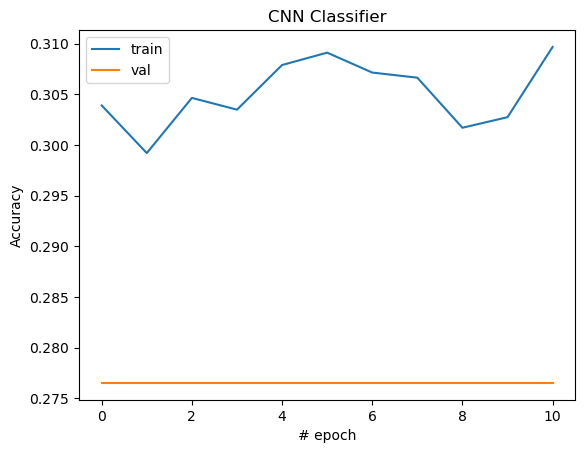

In [143]:
plt.plot(train_metric_history, label='train')
plt.plot(val_metric_history, label='val')
plt.title('CNN Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.show()

Creo que la arquitectura está bien, agregue los embbedings preentrenados uaando:

In [ ]:
embedding_model = Word2VecKeyedVectors.load_word2vec_format('GNvectors.bin', binary=True)
embedding_weights = {key: embedding_model[word] if word in embedding_model else
                          np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                     for key, word in idx2w.items()}

Pero cada que entreno los modelos static y non static me dan cosas distintas, usualmente raras.
Tampoco mejora nunca el accuracy del conjunto de validación